In [1]:
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import pandas as pd
from datetime import date
from CanaryFinancialCalculations import CanaryFinancialCalculations 
import cvxpy as cp
import hvplot.pandas
import warnings
from bokeh.models import HoverTool
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats
from bokeh.models.formatters import DatetimeTickFormatter

In [2]:
warnings.filterwarnings('ignore')

In [3]:
alpaca_api_key = 'PK306FA7SFOSMY9LBUZ4'
alpaca_secret_key = 'oNujbWMi3ZLrZuVggRN1DnZBLs38EJO00cwyOgsE'
base_url = 'https://paper-api.alpaca.markets'

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url,
    api_version="v2")

tickers = ["AZO", "NFLX", "AMD", "BKNG"]
benchmark= ["SPY", "QQQ", "PSI", "IGM"]
timeframe = '1Day'
initial_investment = 10000
weights = [(1 / len(tickers))] * len(tickers)
weights_benchmark = [(1 / len(benchmark))] * len(benchmark)

start_date = pd.Timestamp("2018-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-01", tz="America/New_York").isoformat()


# User Portfolio

In [4]:
portfolio_df = CanaryFinancialCalculations.portfolio_df(tickers, start_date, end_date, timeframe, alpaca)
portfolio_df

symbol,AMD,AZO,BKNG,NFLX
Date,,,,
2018-01-02,10.98,736.54,1784.75,201.070
2018-01-03,11.55,749.43,1824.16,205.050
2018-01-04,12.12,761.26,1807.25,205.630
2018-01-05,11.88,775.50,1823.54,209.990
2018-01-08,12.28,766.48,1851.81,212.050
...,...,...,...,...
2022-12-23,64.52,2430.65,1971.52,294.965
2022-12-27,63.27,2454.32,1998.27,284.170
2022-12-28,62.57,2461.63,1958.84,276.880


In [5]:
weighted_portfolio_df = CanaryFinancialCalculations.weighted_df(portfolio_df, weights)
weighted_portfolio_df

,Portfolio
Date,
2018-01-02,683.33500
2018-01-03,697.54750
2018-01-04,696.56500
2018-01-05,705.22750
2018-01-08,710.65500
...,...
2022-12-23,1190.41375
2022-12-27,1200.00750
2022-12-28,1189.98000


In [6]:
user_portfolio_pct_chg = CanaryFinancialCalculations.portfolio_pct_chg(portfolio_df, weights)
user_portfolio_pct_chg

,Portfolio
Date,
2018-01-03,0.027822
2018-01-04,0.014674
2018-01-05,0.007280
2018-01-08,0.011838
2018-01-09,-0.009317
...,...
2022-12-23,0.008015
2022-12-27,-0.008166
2022-12-28,-0.013368


# Benchmark Dataframe

In [7]:
benchmark_df = CanaryFinancialCalculations.portfolio_df(benchmark, start_date, end_date, timeframe, alpaca)
benchmark_df

symbol,IGM,PSI,QQQ,SPY
Date,,,,
2018-01-02,171.100,51.8100,158.49,268.77
2018-01-03,173.200,52.6199,160.03,270.47
2018-01-04,174.080,52.9805,160.31,271.57
2018-01-05,175.954,53.4000,161.92,273.40
2018-01-08,177.090,53.8500,162.55,273.91
...,...,...,...,...
2022-12-23,279.900,100.4275,267.36,382.91
2022-12-27,276.660,98.9000,263.58,381.40
2022-12-28,272.770,97.2800,260.10,376.66


In [8]:
benchmark_pct_change = CanaryFinancialCalculations.benchmark_pct_chg(benchmark_df)
benchmark_pct_change

symbol,IGM,PSI,QQQ,SPY
Date,,,,
2018-01-03,0.012274,0.015632,0.009717,0.006325
2018-01-04,0.005081,0.006853,0.001750,0.004067
2018-01-05,0.010765,0.007918,0.010043,0.006739
2018-01-08,0.006456,0.008427,0.003891,0.001865
2018-01-09,-0.002428,-0.013928,0.000062,0.002264
...,...,...,...,...
2022-12-23,0.002794,-0.001020,0.002249,0.005752
2022-12-27,-0.011576,-0.015210,-0.014138,-0.003943
2022-12-28,-0.014061,-0.016380,-0.013203,-0.012428


# Combining Portfolio and SPY

In [9]:
comparing_portfolios = pd.concat([user_portfolio_pct_chg, benchmark_pct_change], axis=1, join='inner')
comparing_portfolios

,Portfolio,IGM,PSI,QQQ,SPY
Date,,,,,
2018-01-03,0.027822,0.012274,0.015632,0.009717,0.006325
2018-01-04,0.014674,0.005081,0.006853,0.001750,0.004067
2018-01-05,0.007280,0.010765,0.007918,0.010043,0.006739
2018-01-08,0.011838,0.006456,0.008427,0.003891,0.001865
2018-01-09,-0.009317,-0.002428,-0.013928,0.000062,0.002264
...,...,...,...,...,...
2022-12-23,0.008015,0.002794,-0.001020,0.002249,0.005752
2022-12-27,-0.008166,-0.011576,-0.015210,-0.014138,-0.003943
2022-12-28,-0.013368,-0.014061,-0.016380,-0.013203,-0.012428


# Cumulative Returns

In [10]:
user_cumulative_returns = CanaryFinancialCalculations.cumulative_returns(user_portfolio_pct_chg, initial_investment)
user_cumulative_returns

,Profit
Date,
2018-01-03,10278.22
2018-01-04,10429.04
2018-01-05,10504.97
2018-01-08,10629.32
2018-01-09,10530.29
...,...
2022-12-23,30434.74
2022-12-27,30186.20
2022-12-28,29782.68


In [11]:
spy_returns = CanaryFinancialCalculations.cumulative_returns_benchmark(comparing_portfolios, initial_investment, "SPY")
spy_returns

,SPY
Date,
2018-01-03,10063.25
2018-01-04,10104.18
2018-01-05,10172.27
2018-01-08,10191.24
2018-01-09,10214.31
...,...
2022-12-23,14246.75
2022-12-27,14190.57
2022-12-28,14014.21


In [12]:
igm_returns = CanaryFinancialCalculations.cumulative_returns_benchmark(comparing_portfolios, initial_investment, "IGM")
igm_returns

,IGM
Date,
2018-01-03,10122.74
2018-01-04,10174.17
2018-01-05,10283.69
2018-01-08,10350.09
2018-01-09,10324.96
...,...
2022-12-23,16358.85
2022-12-27,16169.49
2022-12-28,15942.14


In [13]:
psi_returns = CanaryFinancialCalculations.cumulative_returns_benchmark(comparing_portfolios, initial_investment, "PSI")
psi_returns

,PSI
Date,
2018-01-03,10156.32
2018-01-04,10225.92
2018-01-05,10306.89
2018-01-08,10393.75
2018-01-09,10248.99
...,...
2022-12-23,19383.81
2022-12-27,19088.98
2022-12-28,18776.30


In [14]:
qqq_returns = CanaryFinancialCalculations.cumulative_returns_benchmark(comparing_portfolios, initial_investment, "QQQ")
qqq_returns

,QQQ
Date,
2018-01-03,10097.17
2018-01-04,10114.83
2018-01-05,10216.42
2018-01-08,10256.17
2018-01-09,10256.80
...,...
2022-12-23,16869.20
2022-12-27,16630.70
2022-12-28,16411.13


# Correlation

In [15]:
user_rolling_correlation = CanaryFinancialCalculations.rolling_correlation(comparing_portfolios)
user_rolling_correlation

Portfolio   IGM   PSI   QQQ   SPY
Date                                                   
2018-01-17 Portfolio       1.00  0.71  0.59  0.57  0.49
           IGM             0.71  1.00  0.89  0.96  0.88
           PSI             0.59  0.89  1.00  0.80  0.71
           QQQ             0.57  0.96  0.80  1.00  0.93
           SPY             0.49  0.88  0.71  0.93  1.00
...                         ...   ...   ...   ...   ...
2022-12-30 Portfolio       1.00  0.98  0.98  0.98  0.94
           IGM             0.98  1.00  0.98  1.00  0.93
           PSI             0.98  0.98  1.00  0.98  0.88
           QQQ             0.98  1.00  0.98  1.00  0.92
           SPY             0.94  0.93  0.88  0.92  1.00

[6245 rows x 5 columns]

In [16]:
user_correlation = CanaryFinancialCalculations.correlation(comparing_portfolios)
user_correlation

,Portfolio,IGM,PSI,QQQ,SPY
Portfolio,1.00,0.85,0.79,0.84,0.81
IGM,0.85,1.00,0.88,0.99,0.93
PSI,0.79,0.88,1.00,0.87,0.83
QQQ,0.84,0.99,0.87,1.00,0.93
SPY,0.81,0.93,0.83,0.93,1.00


# Covariance

In [17]:
user_covariance = CanaryFinancialCalculations.covariance(comparing_portfolios, "Portfolio", "SPY")
user_covariance

Date
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
2018-01-09         NaN
                ...   
2022-12-23    0.000219
2022-12-27    0.000220
2022-12-28    0.000219
2022-12-29    0.000248
2022-12-30    0.000166
Length: 1258, dtype: float64

# Variance

In [18]:
user_variance = CanaryFinancialCalculations.variance(comparing_portfolios, "SPY")
user_variance

Date
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
2018-01-09         NaN
                ...   
2022-12-23    0.000175
2022-12-27    0.000175
2022-12-28    0.000171
2022-12-29    0.000190
2022-12-30    0.000134
Name: SPY, Length: 1258, dtype: float64

# Beta

In [19]:
user_beta = CanaryFinancialCalculations.beta(user_covariance, user_variance)
user_beta

,Beta
Date,
2018-02-01,1.183638
2018-02-02,1.139588
2018-02-05,1.086309
2018-02-06,1.083101
2018-02-07,1.079957
...,...
2022-12-23,1.252632
2022-12-27,1.256542
2022-12-28,1.281794


# Drawdown

In [20]:
user_daily_drawdown = CanaryFinancialCalculations.daily_drawdown(weighted_portfolio_df)
user_daily_drawdown

,Portfolio
Date,
2018-01-02,0.00
2018-01-03,2.04
2018-01-04,2.04
2018-01-05,3.10
2018-01-08,3.84
...,...
2022-12-23,57.19
2022-12-27,57.19
2022-12-28,57.19


# Annual Returns

In [21]:
user_annual_returns = CanaryFinancialCalculations.annual_return(weighted_portfolio_df, 'Portfolio')
user_annual_returns

12.11

In [22]:
benchmark_annual_return = CanaryFinancialCalculations.annual_return(benchmark_df, 'SPY')
benchmark_annual_return

7.31

# Tracking Error

In [23]:
user_tracking_error = CanaryFinancialCalculations.tracking_error(user_annual_returns, benchmark_annual_return)
user_tracking_error

4.8

# Sharpe Ratio

In [24]:
user_sharpe_ratio = CanaryFinancialCalculations.sharpe_ratio(user_portfolio_pct_chg)
user_sharpe_ratio

,Sharpe Ratio
Portfolio,0.89


# Return on Investment

In [25]:
user_roi = CanaryFinancialCalculations.return_on_investment(user_cumulative_returns, 'Profit', initial_investment)
user_roi

207.55

In [26]:
spy_roi = CanaryFinancialCalculations.return_on_investment(spy_returns, 'SPY', initial_investment)
spy_roi

42.29

In [27]:
igm_roi = CanaryFinancialCalculations.return_on_investment(igm_returns, 'IGM', initial_investment)
igm_roi

63.65

In [28]:
psi_roi = CanaryFinancialCalculations.return_on_investment(psi_returns, 'PSI', initial_investment)
psi_roi

93.17

In [29]:
qqq_roi = CanaryFinancialCalculations.return_on_investment(qqq_returns, 'QQQ', initial_investment)
qqq_roi

68.01

In [30]:
compared_roi = pd.DataFrame({
    'Compared': ['Portfolio', 'SPY', 'IGM', 'PSI', 'QQQ'],
    'Percentage': [user_roi, spy_roi, igm_roi, psi_roi, qqq_roi]
})
compared_roi

,Compared,Percentage
0,Portfolio,207.55
1,SPY,42.29
2,IGM,63.65
3,PSI,93.17
4,QQQ,68.01


# Standard Deviation

In [31]:
user_rolling_std = CanaryFinancialCalculations.standard_deviation(user_portfolio_pct_chg)
user_rolling_std

,Portfolio
Date,
2018-02-01,12.58
2018-02-02,13.27
2018-02-05,16.32
2018-02-06,16.86
2018-02-07,16.79
...,...
2022-12-23,18.11
2022-12-27,18.16
2022-12-28,18.20


In [32]:
user_std = CanaryFinancialCalculations.standard_deviation_mean(user_rolling_std)
user_std

,Average Standard Deviation
Portfolio,17.66


# Portfolio Distribution

In [33]:
user_portfolio_distribution = CanaryFinancialCalculations.portfolio_distribution_chart(tickers, weights)
user_portfolio_distribution

# Cumulative Return Chart

In [34]:
comparing_cumulative_returns_df = CanaryFinancialCalculations.comparing_cumulative_returns(user_cumulative_returns, spy_returns)
comparing_cumulative_returns_df

,Date,Portfolio,SPY
0,2018-01-03,10278.0,10063.0
1,2018-01-04,10429.0,10104.0
2,2018-01-05,10505.0,10172.0
3,2018-01-08,10629.0,10191.0
4,2018-01-09,10530.0,10214.0
...,...,...,...
1253,2022-12-23,30435.0,14247.0
1254,2022-12-27,30186.0,14191.0
1255,2022-12-28,29783.0,14014.0
1256,2022-12-29,30611.0,14266.0


In [35]:
user_cr_chart = CanaryFinancialCalculations.cumulative_return_chart(comparing_cumulative_returns_df, 'Portfolio', 'SPY', 'Date')
user_cr_chart

:Overlay
   .Curve.I  :Curve   [Date]   (Portfolio)
   .Curve.II :Curve   [Date]   (SPY)

# Return on Investment Chart

In [36]:
user_roi_chart = CanaryFinancialCalculations.roi_chart(compared_roi, 'Compared', 'Percentage')
user_roi_chart

:Bars   [Compared]   (Percentage)

# Beta Chart

In [37]:
user_beta_chart = CanaryFinancialCalculations.beta_chart(user_beta)
user_beta_chart 

:Curve   [Date]   (Beta)

# Correlation

In [38]:
user_correlation_scatter_chart = CanaryFinancialCalculations.correlation_scatter_chart(user_rolling_correlation)
user_correlation_scatter_chart

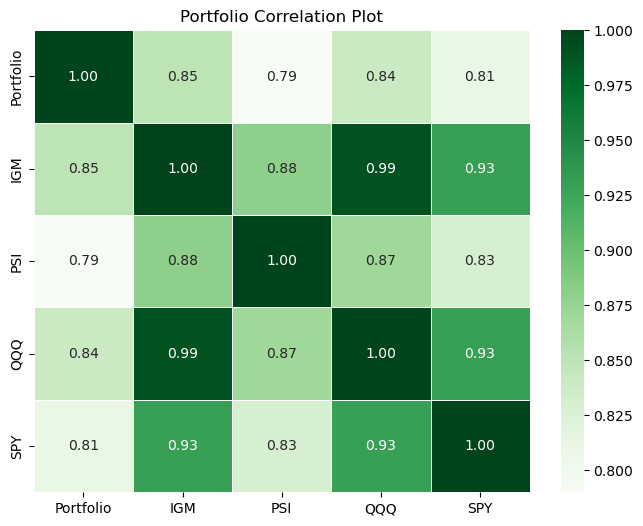

In [ ]:
user_correlation_heatmap = CanaryFinancialCalculations.correlation_heatmap(user_correlation)
user_correlation_heatmap